In [1]:
# -*- coding: utf-8 -*-
"""
Created on Tue Jul 19 12:27:23 2022

@author: b8008458
"""

import pandas as pd
import warnings
import networkx as nx
import geopandas as gpd
import osmnx as ox
from shapely.ops import split
import momepy
from shapely.geometry import Point

#%%


In [2]:

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=PendingDeprecationWarning)
ox.config(use_cache=True, log_console=False)

c:\Users\b8008458\Anaconda3\envs\ox\lib\site-packages\osmnx\utils.py:192: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  warnings.warn(


In [3]:
#%%

place = "York, United Kingdom"
# get location
cities = ox.geocode_to_gdf([place])

# get all amenities for a given study area

tags = {"amenity": ["cafe","pub","restaurant",
                    "college","kindergarten","library","school","university"
                    ,"bicycle_parking","bicycle_repair_station","bicycle_rental","bus_station","ferry_terminal",
                    "taxi","atm","bank","bureau_de_change",
                    "clinic","dentist","doctors","hospital","pharmacy","social_facility","veterinary"
                    ,"arts_centre","cinema","community_centre","public_bookcase",
                    "social_centre", "theatre", 
                    "police", "fire_station", "post_office", "townhall",
                    "drinking_water","toilets","water_point",
                    "recycling"]}

pois = ox.geometries_from_place(place, tags)



# get some barriers
barriers = gpd.read_file(r"C:\Users\b8008458\Documents\2021_2022\Scratch Space\York\Barriers\YorkBarriers.shp")


# get population weighted centroids
pwc = gpd.read_file(r"C:\Users\b8008458\Documents\2021_2022\Scratch Space\York\Centriods\YorkLSOAsSinglePartGPKG.gpkg")
pwc = pwc.to_crs(4326)

In [4]:
# pre-process points of interest
pois = pois.reset_index(drop=True).explode().reset_index(drop=True) # avoid multipart pois
pois['poiID'] = range(0,len(pois))
pois = pois.set_index('poiID')

# convert polygons to points
pois['geometry'] = pois.centroid

# clean columns
pois = pois[['geometry','amenity']]


C:\Users\b8008458\AppData\Local\Temp\ipykernel_15836\1491351608.py:2: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  pois = pois.reset_index(drop=True).explode().reset_index(drop=True) # avoid multipart pois
C:\Users\b8008458\AppData\Local\Temp\ipykernel_15836\1491351608.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  pois['geometry'] = pois.centroid


In [8]:

# function to get isochrones
def get_isochrone(
    lon, lat, walk_times=[15, 30], speed=4.5, name=None, point_index=None
):
    loc = (lat, lon)
    G = ox.graph_from_point(loc, simplify=True, network_type="all")
    gdf_nodes = ox.graph_to_gdfs(G, edges=False)
    center_node = ox.distance.nearest_nodes(G, lon, lat)
    #fig, ax = ox.plot_graph(G,node_color="w", node_size= 50)

    meters_per_minute = speed * 1000 / 60  # km per hour to m per minute
    for u, v, k, data in G.edges(data=True, keys=True):
        data["time"] = data["length"] / meters_per_minute
    polys = []
    for walk_time in walk_times:
        subgraph = nx.ego_graph(G, center_node, radius=walk_time, distance="time")
        node_points = [
            Point(data["x"], data["y"]) for node, data in subgraph.nodes(data=True)
        ]
        polys.append(gpd.GeoSeries(node_points).unary_union.convex_hull)
    info = {}
    if name:
        info["name"] = [name for t in walk_times]
    if point_index:
        info["point_index"] = [point_index for t in walk_times]
    return {**{"geometry": polys, "time": walk_times}, **info}



In [9]:

#%%

WT = [5, 10, 15]
BARRIERS = len(barriers)

# build geopandas data frame of isochrone polygons for each barrier
isochrones = pd.concat(
    [
        gpd.GeoDataFrame(
            get_isochrone(
                r["geometry"].x,
                r["geometry"].y,
                name=r["globalid"],
                point_index=i,
                walk_times=WT,
            ),
            crs=barriers.crs,
        )
        for i, r in barriers.head(BARRIERS).iterrows()
    ]
)



In [8]:
isochrones.head(15)
#isochrones.to_file(r"C:\Users\b8008458\Documents\2021_2022\Scratch Space\isochrones.shp")

,geometry,time,name,point_index
0,"POLYGON ((-1.08139 53.94271, -1.08546 53.94372...",5,54ade712-9b6c-4716-96c0-9efb9f62d005,NaN
1,"POLYGON ((-1.08404 53.93939, -1.08751 53.94026...",10,54ade712-9b6c-4716-96c0-9efb9f62d005,NaN
2,"POLYGON ((-1.08063 53.93702, -1.08855 53.93765...",15,54ade712-9b6c-4716-96c0-9efb9f62d005,NaN
0,"POLYGON ((-1.08118 53.94163, -1.08152 53.94167...",5,f6daa07a-d3e7-4f04-abd9-4cae134e562f,1.0
1,"POLYGON ((-1.08093 53.93835, -1.08871 53.94361...",10,f6daa07a-d3e7-4f04-abd9-4cae134e562f,1.0
2,"POLYGON ((-1.07657 53.93622, -1.07957 53.93672...",15,f6daa07a-d3e7-4f04-abd9-4cae134e562f,1.0
0,"POLYGON ((-1.08146 53.94118, -1.08170 53.94120...",5,49d7398c-c98a-4466-903b-6e05a146eed8,2.0
1,"POLYGON ((-1.08010 53.93825, -1.08191 53.93830...",10,49d7398c-c98a-4466-903b-6e05a146eed8,2.0
2,"POLYGON ((-1.07657 53.93622, -1.07957 53.93672...",15,49d7398c-c98a-4466-903b-6e05a146eed8,2.0
0,"POLYGON ((-1.08106 53.94190, -1.08133 53.94203...",5,763d1bb1-363d-4bc6-b6e6-0efdee707937,3.0


In [10]:

#%%

warnings.filterwarnings("ignore")

gdf = isochrones.set_index(["time", "point_index"]).copy()
# remove shorter walk time from longer walk time polygon to make folium work better
for idx in range(len(WT)-1,0,-1):
    gdf.loc[WT[idx], "geometry"] = (
        gdf.loc[WT[idx]]
        .apply(
            lambda r: r["geometry"].symmetric_difference(
                gdf.loc[(WT[idx-1], r.name), "geometry"]
            ),
            axis=1,
        )
        .values
    )

m = gdf.reset_index().explore(column="time", scheme="boxplot")
barriers.head(BARRIERS).explore(m=m, marker_kwds={"radius": 3, "color": "red"})


With Isochrones calcualted, find PWC within 15 minutes of barrier

In [11]:
# remove shorter walk distances
isochrones = isochrones[isochrones.time == 15]
isochrones['point_index'] = isochrones['point_index'].fillna(0)
isochrones.head(10)

,geometry,time,name,point_index
2,"POLYGON ((-1.08063 53.93702, -1.08855 53.93765...",15,54ade712-9b6c-4716-96c0-9efb9f62d005,0.0
2,"POLYGON ((-1.07657 53.93622, -1.07957 53.93672...",15,f6daa07a-d3e7-4f04-abd9-4cae134e562f,1.0
2,"POLYGON ((-1.07657 53.93622, -1.07957 53.93672...",15,49d7398c-c98a-4466-903b-6e05a146eed8,2.0
2,"POLYGON ((-1.07957 53.93672, -1.08057 53.93690...",15,763d1bb1-363d-4bc6-b6e6-0efdee707937,3.0
2,"POLYGON ((-1.08073 53.93727, -1.08751 53.94026...",15,66f3469b-9eb5-497f-b0c3-ebb2d8c8c076,4.0
2,"POLYGON ((-1.07314 53.93627, -1.07398 53.93637...",15,69970194-9501-4692-8fbb-e0ccbefa9714,5.0
2,"POLYGON ((-1.07304 53.93710, -1.07580 53.93827...",15,1f1be6c4-7beb-4c15-8cc2-96973ee6e4c1,6.0
2,"POLYGON ((-1.06466 53.93954, -1.07422 53.94051...",15,3b22a61e-5772-4272-81a4-aa4160ad6492,7.0
2,"POLYGON ((-1.06164 53.93867, -1.06330 53.93870...",15,f03d5d9e-dd6a-4995-84e1-843deef6cd7e,8.0
2,"POLYGON ((-1.06017 53.94089, -1.06307 53.94119...",15,866c3440-d9cd-44ff-abef-5aea510dccdd,9.0


In [26]:
isochrones

,geometry,time,name,point_index
2,"POLYGON ((-1.08063 53.93702, -1.08855 53.93765...",15,54ade712-9b6c-4716-96c0-9efb9f62d005,0.0
2,"POLYGON ((-1.07657 53.93622, -1.07957 53.93672...",15,f6daa07a-d3e7-4f04-abd9-4cae134e562f,1.0
2,"POLYGON ((-1.07657 53.93622, -1.07957 53.93672...",15,49d7398c-c98a-4466-903b-6e05a146eed8,2.0
2,"POLYGON ((-1.07957 53.93672, -1.08057 53.93690...",15,763d1bb1-363d-4bc6-b6e6-0efdee707937,3.0
2,"POLYGON ((-1.08073 53.93727, -1.08751 53.94026...",15,66f3469b-9eb5-497f-b0c3-ebb2d8c8c076,4.0
2,"POLYGON ((-1.07314 53.93627, -1.07398 53.93637...",15,69970194-9501-4692-8fbb-e0ccbefa9714,5.0
2,"POLYGON ((-1.07304 53.93710, -1.07580 53.93827...",15,1f1be6c4-7beb-4c15-8cc2-96973ee6e4c1,6.0
2,"POLYGON ((-1.06466 53.93954, -1.07422 53.94051...",15,3b22a61e-5772-4272-81a4-aa4160ad6492,7.0
2,"POLYGON ((-1.06164 53.93867, -1.06330 53.93870...",15,f03d5d9e-dd6a-4995-84e1-843deef6cd7e,8.0
2,"POLYGON ((-1.06017 53.94089, -1.06307 53.94119...",15,866c3440-d9cd-44ff-abef-5aea510dccdd,9.0


In [11]:
pwc.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [12]:
join_inner_df = pwc.sjoin(isochrones, how='left')

In [13]:
join_inner_df = join_inner_df.dropna()
# drop repeated points
# THIS IS FOR TESTING ONLY
join_inner_df = join_inner_df.drop_duplicates(subset = ['lsoa11cd'])
len(join_inner_df)
pwc_test = join_inner_df

In [147]:
#result = join_inner_df.groupby('name').size()
result = join_inner_df.groupby('lsoa11nm')

Now calculate isochrones from selected 

Now split the network at barrier locations to prevent routes to pass through and caulcuate isochrones for PWC within walking distance of barriers

In [48]:

# function to get isochrones
def get_isochrone_barriers(
    lon, lat, walk_times=[15, 30], speed=4.5, name=None, point_index=None
):
    loc = (lat, lon)
    G = ox.graph_from_place("York, United Kingdom", simplify=True, network_type="all")
    #print("original G", G)
    #fig, ax = ox.plot_graph(G, node_color="r")
    # disconnect network at barriers
    #######
    G_edges = ox.graph_to_gdfs(ox.get_undirected(G), nodes=False, edges=True, node_geometry=False, fill_edge_geometry=True)
    G_nodes = ox.graph_to_gdfs(ox.get_undirected(G), nodes=True, edges=False, node_geometry=True, fill_edge_geometry=False)
    shply_line = G_edges.geometry.unary_union
    point = barriers.to_crs(G_edges.crs)
    for i in range(len(point)):
        shply_line.interpolate(shply_line.project( point.geometry[i]))
    result = point.copy()
    result['geometry'] = result.apply(lambda row: shply_line.interpolate(shply_line.project( row.geometry)), axis=1)
    buffer = result.geometry.buffer(0.00001)
    broken_network = G_edges.intersects(buffer.unary_union)
    broken_network = pd.DataFrame(broken_network)
    broken_network.rename(columns = {0:'Clipped'}, inplace = True)
    broken_network = pd.concat([broken_network,G_edges],axis=1)
    # drop intersected lines
    broken_network.drop(broken_network[broken_network['Clipped'] == True].index, inplace=True)
    broken_network = broken_network[['geometry','to','from']]
    broken_network = gpd.GeoDataFrame(broken_network, geometry='geometry')
    G_edges = broken_network.to_crs(3857)
    G_edges['length'] = G_edges.length
    G_edges = G_edges.to_crs(4326)
    print("G_edges",G_edges)
    G_nodes['x'] = G_nodes.geometry.apply(lambda p: p.x)
    G_nodes['y'] = G_nodes.geometry.apply(lambda p: p.y)
    G = ox.graph_from_gdfs(G_nodes, G_edges)
    #print("G processed",G)
    #fig, ax = ox.plot_graph(G, node_color="r")
    #########
    gdf_nodes = ox.graph_to_gdfs(G, edges=False) # momepy.nx_to_gdf(G, lines=False)
    center_node = ox.distance.nearest_nodes(G, lon, lat)

    meters_per_minute = speed * 1000 / 60  # km per hour to m per minute
    for u, v, k, data in G.edges(data=True, keys=True):
        data["time"] = data["length"] / meters_per_minute
    polys = []
    for walk_time in walk_times:
        subgraph = nx.ego_graph(G, center_node, radius=walk_time, distance="time")
        node_points = [
            Point(data["x"], data["y"]) for node, data in subgraph.nodes(data=True)
        ]
        polys.append(gpd.GeoSeries(node_points).unary_union.convex_hull)
    info = {}
    if name:
        info["name"] = [name for t in walk_times]
    if point_index:
        info["point_index"] = [point_index for t in walk_times]
    return {**{"geometry": polys, "time": walk_times}, **info}

In [49]:
#%%

WT = [5, 10, 15]
PWC_TEST = len(pwc_test)

# build geopandas data frame of isochrone polygons for each barrier
isochrones_pwc = pd.concat(
    [
        gpd.GeoDataFrame(
            get_isochrone_barriers(
                r["geometry"].x,
                r["geometry"].y,
                name=r["lsoa11cd"],
                point_index=i,
                walk_times=WT,
            ),
            crs=pwc_test.crs,
        )
        for i, r in pwc_test.head(PWC_TEST).iterrows()
    ]
)



G_edges                                                                     geometry  \
u          v          key                                                      
3470523    9230022776 0    LINESTRING (-1.02349 53.98963, -1.02359 53.98965)   
           3470558    0    LINESTRING (-1.02251 53.98989, -1.02261 53.989...   
           27189468   0    LINESTRING (-1.02329 53.98908, -1.02331 53.989...   
3470533    2669055381 0    LINESTRING (-1.02393 53.99038, -1.02385 53.99051)   
           3470543    0    LINESTRING (-1.02393 53.99038, -1.02377 53.990...   
...                                                                      ...   
9898920626 9898920631 0    LINESTRING (-1.07268 53.96449, -1.07270 53.964...   
           9898920656 0    LINESTRING (-1.07288 53.96475, -1.07287 53.964...   
9898920631 9898920636 0    LINESTRING (-1.07258 53.96438, -1.07261 53.964...   
9898920636 9898920653 0    LINESTRING (-1.07210 53.96377, -1.07209 53.963...   
9898920653 9898920653 0    LINES

In [51]:
isochrones_pwc.to_file(r"C:\Users\b8008458\Documents\2021_2022\Scratch Space\isochrones_pwc.gpkg")

In [50]:
#%%

warnings.filterwarnings("ignore")

gdf = isochrones_pwc.set_index(["time", "point_index"]).copy()
# remove shorter walk time from longer walk time polygon to make folium work better
for idx in range(len(WT)-1,0,-1):
    gdf.loc[WT[idx], "geometry"] = (
        gdf.loc[WT[idx]]
        .apply(
            lambda r: r["geometry"].symmetric_difference(
                gdf.loc[(WT[idx-1], r.name), "geometry"]
            ),
            axis=1,
        )
        .values
    )

m = gdf.reset_index().explore(column="time", scheme="boxplot")
pwc.head(PWC).explore(m=m, marker_kwds={"radius": 3, "color": "red"})

TypeError: 'NoneType' object is not subscriptable

TESTING


In [17]:
# remove shorter walk distances
isochrones = isochrones[isochrones.time == 15]
isochrones['point_index'] = isochrones['point_index'].fillna(0)
isochrones.head(10)

,geometry,time,name,point_index
2,"POLYGON ((-1.08315 53.94550, -1.08348 53.94570...",15,54ade712-9b6c-4716-96c0-9efb9f62d005,0.0
2,"POLYGON ((-1.08092 53.94360, -1.08142 53.94443...",15,f6daa07a-d3e7-4f04-abd9-4cae134e562f,1.0
2,POINT (-1.08069 53.94422),15,49d7398c-c98a-4466-903b-6e05a146eed8,2.0
2,"POLYGON ((-1.08087 53.94502, -1.07985 53.94672...",15,763d1bb1-363d-4bc6-b6e6-0efdee707937,3.0
2,"POLYGON ((-1.07714 53.94467, -1.07883 53.94506...",15,66f3469b-9eb5-497f-b0c3-ebb2d8c8c076,4.0
2,"POLYGON ((-1.07367 53.94501, -1.07367 53.94520...",15,69970194-9501-4692-8fbb-e0ccbefa9714,5.0
2,POINT (-1.07257 53.94599),15,1f1be6c4-7beb-4c15-8cc2-96973ee6e4c1,6.0
2,POINT (-1.06616 53.94613),15,3b22a61e-5772-4272-81a4-aa4160ad6492,7.0
2,"LINESTRING (-1.05978 53.94750, -1.05970 53.94750)",15,f03d5d9e-dd6a-4995-84e1-843deef6cd7e,8.0
2,"POLYGON ((-1.05770 53.94928, -1.05904 53.94947...",15,866c3440-d9cd-44ff-abef-5aea510dccdd,9.0


In [11]:
join_inner_df = pois.sjoin(isochrones, how='inner')

In [12]:
result_barriers = join_inner_df.groupby('name').size()

In [15]:
result_barriers

name
332dc7cd-e64d-4685-bb4c-bab1cd855a12     4
66f3469b-9eb5-497f-b0c3-ebb2d8c8c076     2
7591f312-512b-45dc-97ff-a9cbba478ede     1
763d1bb1-363d-4bc6-b6e6-0efdee707937     2
866c3440-d9cd-44ff-abef-5aea510dccdd     1
c985537b-4753-4f38-9bd1-aca1a26efad7    20
f6daa07a-d3e7-4f04-abd9-4cae134e562f     4
dtype: int64

In [16]:

G = ox.graph_from_place("York, United Kingdom", simplify=True, network_type="all")
print(G)
G_edges = ox.graph_to_gdfs(ox.get_undirected(G), nodes=False, edges=True, node_geometry=False, fill_edge_geometry=True)
G_nodes = ox.graph_to_gdfs(ox.get_undirected(G), nodes=True, edges=False, node_geometry=True, fill_edge_geometry=False)
shply_line = G_edges.geometry.unary_union
point = barriers.to_crs(G_edges.crs)
for i in range(len(point)):
    print(shply_line.interpolate(shply_line.project( point.geometry[i])).wkt)
result = point.copy()
result['geometry'] = result.apply(lambda row: shply_line.interpolate(shply_line.project( row.geometry)), axis=1)
buffer = result.geometry.buffer(0.00001)
broken_network = G_edges.intersects(buffer.unary_union)
broken_network = pd.DataFrame(broken_network)
broken_network.rename(columns = {0:'Clipped'}, inplace = True)
broken_network = pd.concat([broken_network,G_edges],axis=1)

# drop intersected lines
broken_network.drop(broken_network[broken_network['Clipped'] == True].index, inplace=True)
broken_network = broken_network[['geometry','to','from']]
broken_network = gpd.GeoDataFrame(broken_network, geometry='geometry')
G_edges = broken_network.to_crs(3857)
G_edges['length'] = G_edges.length
G_edges = G_edges.to_crs(4326)
# G = ox.graph_from_gdfs(G_nodes, G_edges)
G_after_processing = ox.graph_from_gdfs(G_nodes, G_edges)
G_after_processing2 = momepy.nx_to_gdf(G_after_processing)
print(G_after_processing)
#G_after_processing.to_file(r"C:\Users\b8008458\Documents\2021_2022\Scratch Space\G_after_processing.shp")
#G.to_file(r"C:\Users\b8008458\Documents\2021_2022\Scratch Space\G.shp")
    

G_edges                                                                     geometry  \
u          v          key                                                      
3470523    9230022776 0    LINESTRING (-1.02349 53.98963, -1.02359 53.98965)   
           3470558    0    LINESTRING (-1.02251 53.98989, -1.02261 53.989...   
           27189468   0    LINESTRING (-1.02329 53.98908, -1.02331 53.989...   
3470533    2669055381 0    LINESTRING (-1.02393 53.99038, -1.02385 53.99051)   
           3470543    0    LINESTRING (-1.02393 53.99038, -1.02377 53.990...   
...                                                                      ...   
9898920626 9898920631 0    LINESTRING (-1.07268 53.96449, -1.07270 53.964...   
           9898920656 0    LINESTRING (-1.07288 53.96475, -1.07287 53.964...   
9898920631 9898920636 0    LINESTRING (-1.07258 53.96438, -1.07261 53.964...   
9898920636 9898920653 0    LINESTRING (-1.07210 53.96377, -1.07209 53.963...   
9898920653 9898920653 0    LINES

In [19]:
{"geometry": polys, "time": walk_times}

{'geometry': [<shapely.geometry.point.Point at 0x2262a017fd0>,
 'time': [15, 30]}

In [20]:
polys

In [20]:
G_edges.to_file(r"C:\Users\b8008458\Documents\2021_2022\Scratch Space\G_edges.shp")
G_nodes.to_file(r"C:\Users\b8008458\Documents\2021_2022\Scratch Space\G_nodes.shp")

In [21]:
test3 = momepy.gdf_to_nx(G_edges, approach='primal')

In [54]:
edges = ox.graph_to_gdfs(ox.get_undirected(G), nodes=False, edges=True, node_geometry=False, fill_edge_geometry=True)

In [55]:
edges.drop(["ref","name","maxspeed","lanes","service","bridge","tunnel","access","junction","width","est_width", "osmid"], axis=1, inplace=True)
edges['highway'] = edges['highway'].str.replace("'"," ")

In [56]:
edges.to_file(r"C:\Users\b8008458\Documents\2021_2022\Scratch Space\G.shp")

ValueError: Invalid field type <class 'list'>

In [53]:
G_output = pd.DataFrame(G_output)

In [52]:
G_output.to_file(r"C:\Users\b8008458\Documents\2021_2022\Scratch Space\testoutput.shp")

AttributeError: 'tuple' object has no attribute 'to_file'

In [47]:
G.type()

AttributeError: 'MultiDiGraph' object has no attribute 'type'

In [18]:
test = ox.graph_from_place('York, United Kingdom', network_type="all",clean_periphery=True, simplify=True)

In [44]:
loc

(-1.08306, 53.94546)

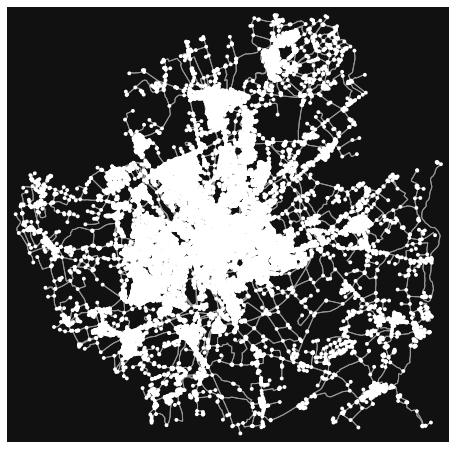

In [19]:
fig, ax = ox.plot_graph(
    test, node_color="w")

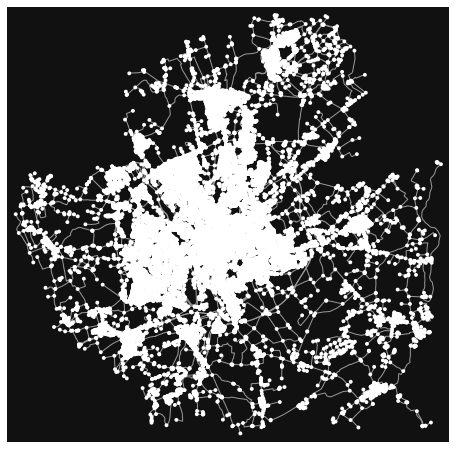

In [20]:
fig, ax = ox.plot_graph(
    G, node_color="w")

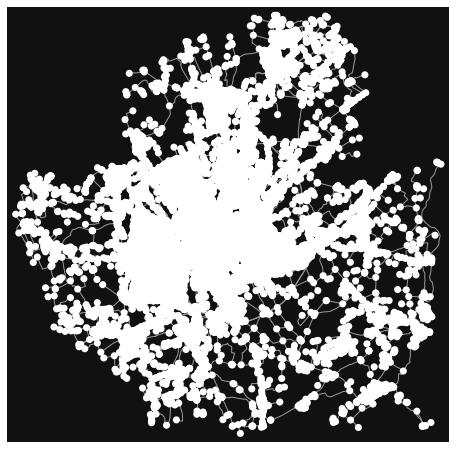

In [7]:
fig, ax = ox.plot_graph(G,node_color="w", node_size= 50)

In [17]:
center_node = ox.distance.nearest_nodes(G, lon, lat)

,nodeID,geometry
0,1,POINT (-113934.675 7168192.149)
1,2,POINT (-113945.707 7168195.557)
2,3,POINT (-113825.682 7168242.135)
3,4,POINT (-113912.578 7168089.073)
4,5,POINT (-113983.478 7168334.421)
...,...,...
27465,27466,POINT (-115187.743 7175682.225)
27466,27467,POINT (-115189.235 7175670.001)
27467,27468,POINT (-115186.852 7175695.662)
27468,27469,POINT (-119307.622 7163362.010)


NEW PLAn


In [25]:
#!pip install -U pychrone
#!pip install geojson
#!pip install geopy

     -------------------------------------- 118.9/118.9 kB 3.5 MB/s eta 0:00:00


In [26]:
import geojson
import geopy
import pychrone

In [29]:
from pychrone import Create_isochrone
Create_isochrone(37.847591, 55.920284, 5, speed=15, route='bike')

TypeError: graph_from_point() got an unexpected keyword argument 'distance'